<a href="https://colab.research.google.com/github/DorcasO/DorcasO/blob/main/New_CambridgeChatbotAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Step1: Mount Google Drive To save our scraped data persistently, we mount Google Drive to access its file system from Colab.


In [13]:
import os

#Define path inside your Google Drive
drive_path = "/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

# Create the folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

Step 2: Create Output Folder. We define the path to a folder named Knowledgebase_data inside your Google Drive. If the folder doesn't exist, we create it using os.makedirs().

In [14]:
#Create the folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

Install core libraries

In [3]:
pip install -q transformers sentence-transformers faiss-cpu langchain gradio chromadb qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 8.1 MB/s eta 0

In [4]:
pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
pip install requests beautifulsoup4

In [1]:
import requests
from bs4 import BeautifulSoup
import os

In [9]:
#Define Target Pages
pages = {
    "undergraduate_courses": "https://www.undergraduate.study.cam.ac.uk/courses",
    "fees_and_funding": "https://www.cambridgestudents.cam.ac.uk/fees-and-funding/fees",
    "colleges_and_departments": "https://www.cam.ac.uk/colleges-and-departments/college-a-z",
    "admin":"https://www.afpa.admin.cam.ac.uk/",
    "fees_and_finance":"https://www.undergraduate.study.cam.ac.uk/fees-and-finance",
    "living_costs":"https://www.undergraduate.study.cam.ac.uk/fees-and-finance/living-costs",
    "international_fees_and_costs":"https://www.undergraduate.study.cam.ac.uk/international-students/international-fees-and-costs",
    "finance_and_support":"https://www.undergraduate.study.cam.ac.uk/finance_and_support",
    "entry_requirements":"https://www.undergraduate.study.com/entry-requirements",
    "application_process":"https://www.undergraduate.study.com/application-process",
    "student_life":"https://www.undergraduate.study.cam.ac.uk/student-life",
    "events_open_days":"https://www.undergraduate.study.cam.ac.uk/events-open-days",
    "news":"https://www.undergraduate.study.cam.ac.uk/news",
    "research":"https://www.undergraduate.study.cam.ac.uk/research",
    "careers":"https://www.undergraduate.study.cam.ac.uk/careers",
    "about_us":"https://www.undergraduate.study.cam.ac.uk/about-us",
    "contact_us":"https://www.undergraduate.study.cam.ac.uk/contact-us"
}

Step 5: Web Scraping Function This function:

Sends a GET request to the given URL Parses HTML using BeautifulSoup Extracts the page title and all paragraphs (

) Returns them as a list of strings

In [10]:
def scrape_page(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        title = soup.title.text.strip() if soup.title else "No Title"
        paragraphs = [p.text.strip() for p in soup.find_all("p") if p.text.strip()]
        return title, paragraphs
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return "Error", []

Step 6: Save Data as Markdown File This function:

Combines the scraped title and content into markdown format Saves the file inside your Google Drive folder as filename.md

In [11]:
def save_to_markdown(title, paragraphs, filename):
    filepath = os.path.join(drive_path, f"{filename}.md")
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(f"# {title}\n\n")
        for para in paragraphs:
            f.write(f"{para}\n\n")
    print(f"✅ Saved to: {filepath}")

Step 7: Loop Through Pages and Save Results For each page in our list:

Scrape the content using scrape_page() Save it as a .md file using save_to_markdown()

In [15]:
for filename, url in pages.items():
    print(f"Scraping: {url}")
    title, content = scrape_page(url)
    save_to_markdown(title, content, filename)


Scraping: https://www.undergraduate.study.cam.ac.uk/courses
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/undergraduate_courses.md
Scraping: https://www.cambridgestudents.cam.ac.uk/fees-and-funding/fees
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/fees_and_funding.md
Scraping: https://www.cam.ac.uk/colleges-and-departments/college-a-z
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/colleges_and_departments.md
Scraping: https://www.afpa.admin.cam.ac.uk/
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/admin.md
Scraping: https://www.undergraduate.study.cam.ac.uk/fees-and-finance
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/fees_and_finance.md
Scraping: https://www.undergraduate.study.cam.ac.uk/fees-and-finance/living-costs
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/living_costs.md
Scraping: https://www.undergraduate.study.cam.ac.uk/international-students/international-fees-an

In [5]:
%cd /content/drive/MyDrive/AMDARI

/content/drive/MyDrive/AMDARI


In [6]:
pwd

'/content/drive/MyDrive/AMDARI'

In [17]:
import os
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
KB_PATH = "/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

files = [os.path.join(KB_PATH, f) for dp, _, fn in os.walk(KB_PATH) for f in fn if f.endswith(".md")]
docs = [doc for f in files for doc in TextLoader(f, encoding="utf-8").load()]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(docs)
texts = [chunk.page_content for chunk in chunks]
print(f" {len(chunks)} chunks generated.")


 66 chunks generated.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

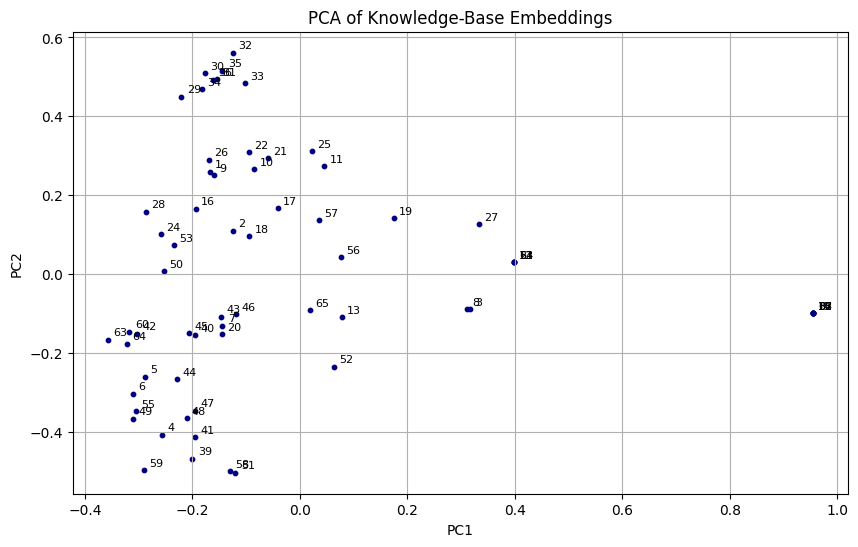

In [18]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Embed all chunks
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
texts = [chunk.page_content for chunk in  chunks]
embeddings = embed_model.encode(texts, show_progress_bar=True)

# 2. PCA to 2 dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

#3. Plot
plt.figure(figsize=(10, 6))
for i, (x,y) in enumerate(reduced):
  plt.scatter(x, y, s=10, c="navy")
  plt.text(x + 0.01, y + 0.01, str(i), fontsize=8)
plt.title("PCA of Knowledge-Base Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [19]:
import faiss
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

# 1. Raw FAISS index
dim = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dim)
faiss_index.add(np.array(embeddings, dtype="float32"))

# 2. Prepare LangChain wrapper
docs = [Document(page_content=t) for t in texts]
docstore = InMemoryDocstore({str(i): docs[i] for i in range(len(docs))})
id_map = {i: str(i) for i in range(len(docs))}
embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore_faiss = LangChainFAISS(
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embed_fn
)

print("  FAISS vectorstore ready.")

/tmp/ipython-input-19-2577777517.py:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


  FAISS vectorstore ready.


In [21]:
# Save FAISS index
faiss.write_index(faiss_index, "faiss_index.idx")

# Save docstore and id_map using pickle
import pickle

with open("docstore.pkl", "wb") as f:
    pickle.dump(docstore, f)

with open("id_map.pkl", "wb") as f:
    pickle.dump(id_map, f)
# from google.colab import drive
# drive.mount('/content/drive')

# Move files to Google Drive
!cp faiss_index.idx /content/drive/MyDrive/AMDARI
!cp docstore.pkl /content/drive/MyDrive/AMDARI
!cp id_map.pkl /content/drive/MyDrive/AMDARI



cp: 'faiss_index.idx' and '/content/drive/MyDrive/AMDARI/faiss_index.idx' are the same file
cp: 'docstore.pkl' and '/content/drive/MyDrive/AMDARI/docstore.pkl' are the same file
cp: 'id_map.pkl' and '/content/drive/MyDrive/AMDARI/id_map.pkl' are the same file


In [23]:
import os

os.listdir('/content/drive/MyDrive/AMDARI')


['id_map.pkl', 'Cambridge_scraped_data', 'faiss_index.idx', 'docstore.pkl']

In [ ]:
# Load FAISS index
index = faiss.read_index("faiss_index.idx")

# Load docstore and id_map
with open("docstore.pkl", "rb") as f:
    docstore = pickle.load(f)

with open("id_map.pkl", "rb") as f:
    id_map = pickle.load(f)

# Recreate the embedding function
embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Rebuild vectorstore
vectorstore_faiss = LangChainFAISS(
    index=index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embed_fn
)


In [20]:
query = "what is Cambridge University about?"
results = vectorstore_faiss.similarity_search(query, k=3)

print("Top-3 FAISS Results:")
for i, doc in enumerate(results):
  print(f"\n- Passage {i+1}:\n{doc.page_content[:300]}...")


Top-3 FAISS Results:

- Passage 1:
The opportunities at Cambridge are like no other – from participating in clubs and societies to finding your way around College and learning to live independently. Most of all, the chance to study a subject you love while surrounded by students and academics who are just as passionate about it as yo...

- Passage 2:
# College A-Z | University of Cambridge

Colleges and Departments

The University of Cambridge has 31 Colleges. All undergraduate students at Cambridge join a College where they live, eat and socialise.

The Colleges provide academic and pastoral support to undergraduates and postgraduates. Each Col...

- Passage 3:
# Student life at Cambridge | Undergraduate Study

Undergraduate Study

Cambridge is a great place to be a student. There’s loads going on in the University, the Colleges and the city.

As a Cambridge student you:

At Cambridge you'll be offered a world-class education, as well as an exceptional stu...


In [ ]:
# import chromadb
# from chromadb.config import Settings
# from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

# # 1. Initialize persistent client (will create 'chroma_data/' locally)
# client = chromadb.PersistentClient(
#     path="chroma_data",
#     settings=Settings()
# )

# # 2. Create or load a collection named "Cambridge University"
# collection = client.get_or_create_collection(
#     name="CambridgeUniversity",
#     embedding_function=SentenceTransformerEmbeddingFunction(
#         model_name="sentence-transformers/all-MiniLM-L6-V2"
#     )
# )

# # 3. Upsert your chunks (ids + documents)
# ids = [str(i) for i in range(len(texts))]
# collection.upsert(
#     documents=texts,
#     ids=ids
# )
# # 4. Query for top-3 similar passages

# query = "What is Cambridge University about?"
# resp = collection.query(
#     query_texts=[query],
#     n_results=3
# )
# print("Top-3 ChromaDB Results:")
# for doc in resp["documents"][0]:
#     print("-", doc[:200].replace("\n"," "), "...")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Top-3 ChromaDB Results:
- The opportunities at Cambridge are like no other – from participating in clubs and societies to finding your way around College and learning to live independently. Most of all, the chance to study a s ...
- # College A-Z | University of Cambridge  Colleges and Departments  The University of Cambridge has 31 Colleges. All undergraduate students at Cambridge join a College where they live, eat and socialis ...
- # Student life at Cambridge | Undergraduate Study  Undergraduate Study  Cambridge is a great place to be a student. There’s loads going on in the University, the Colleges and the city.  As a Cambridge ...


In [24]:
import faiss
import pickle
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import HuggingFaceEmbeddings

# ✅ 1. Set your Google Drive FAISS folder path
faiss_folder = "/content/drive/MyDrive/AMDARI"

# ✅ 2. Load the saved FAISS index, docstore, and id_map
faiss_index = faiss.read_index(f"{faiss_folder}/faiss_index.idx")

with open(f"{faiss_folder}/docstore.pkl", "rb") as f:
    docstore = pickle.load(f)

with open(f"{faiss_folder}/id_map.pkl", "rb") as f:
    id_map = pickle.load(f)

# ✅ 3. Set up the same embedding function you used before
embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# ✅ 4. Rebuild the FAISS vectorstore
vectorstore = LangChainFAISS(
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embed_fn
)

# ✅ 5. Perform a search
query = "What is Cambridge University about?"

results = vectorstore.similarity_search(query, k=3)

# ✅ 6. Print top-3 matched documents
print("🔍 Top-3 FAISS Search Results:")
for i, doc in enumerate(results, 1):
    print(f"{i}.", doc.page_content[:200].replace("\n", " "), "...")


🔍 Top-3 FAISS Search Results:
1. The opportunities at Cambridge are like no other – from participating in clubs and societies to finding your way around College and learning to live independently. Most of all, the chance to study a s ...
2. # College A-Z | University of Cambridge  Colleges and Departments  The University of Cambridge has 31 Colleges. All undergraduate students at Cambridge join a College where they live, eat and socialis ...
3. # Student life at Cambridge | Undergraduate Study  Undergraduate Study  Cambridge is a great place to be a student. There’s loads going on in the University, the Colleges and the city.  As a Cambridge ...


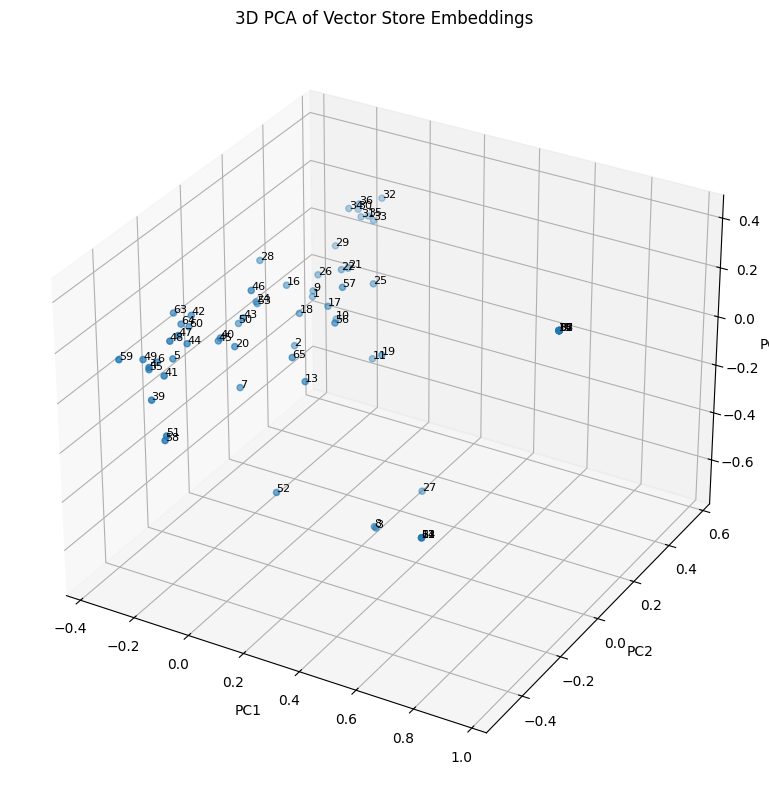

In [25]:
# 3D PCA Visualization of Your Vector Store Embeddings

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Extract FAISS index
faiss_idx = vectorstore_faiss.index
n = faiss_idx.ntotal

# 2. Reconstruct all vectors
emb_arr = np.vstack([faiss_idx.reconstruct(i) for i in range(n)])

# 3. Reduce to 3D
pca3 = PCA(n_components=3)
embeddings_3d = pca3.fit_transform(emb_arr)

# 4. Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2]
ax.scatter(xs, ys, zs)

# Annotate each point with its index
for i in range(n):
    ax.text(xs[i], ys[i], zs[i], str(i), fontsize=8)

ax.set_title("3D PCA of Vector Store Embeddings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

"/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

In [ ]:
# from sentence_transformers import SentenceTransformer
# import faiss, numpy as np
# from langchain.vectorstores import FAISS as LangChainFAISS
# from langchain.docstore import InMemoryDocstore
# from langchain.embeddings import HuggingFaceEmbeddings
# from langchain.schema import Document

# # 1. Generate embeddings
# embed_model_id = "sentence-transformers/all-MiniLM-L6-v2"
# embedder = SentenceTransformer(embed_model_id)
# embeddings = embedder.encode(texts, show_progress_bar=True)

# # 2. Build raw FAISS index
# dim = embeddings.shape[1]
# index = faiss.IndexFlatL2(dim)
# index.add(np.array(embeddings, dtype="float32"))

# # 3. Wrap in LangChain FAISS
# docs = [Document(page_content=t) for t in texts]
# docstore = InMemoryDocstore({str(i): docs[i] for i in range(len(docs))})
# id_map = {i: str(i) for i in range(len(docs))}
# embed_fn = HuggingFaceEmbeddings(model_name=embed_model_id)

# vectorstore_faiss = LangChainFAISS(
#     index=index,
#     docstore=docstore,
#     index_to_docstore_id=id_map,
#     embedding_function=embed_fn
# )

# print("✅ FAISS vectorstore is ready.")


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

✅ FAISS vectorstore is ready.


In [ ]:
#Block 3: Generate Embeddings & Build the FAISS Vectorstore With text chunks in hand, we:

#Embed every chunk into a high-dimensional vector using the all-MiniLM-L6-v2 sentence transformer.
#Create a FAISS flat L2 index (IndexFlatL2) and add all chunk embeddings—this lets us do lightning-fast nearest-neighbor searches.
#Wrap the FAISS index in LangChain’s FAISS class, linking each vector back to its original text chunk for easy retrieval.
#At the end of this cell, we have a fully functional vector database ready to answer semantic similarity queries.

Block 4: Load all-MiniLM-L6-v2 & Define the Retrieval + Generation Function
This is the heart of our RAG pipeline:

Load the  model="google/flan-t5-large" & tokenizer from Drive (so we don’t re-download every run) and move it to GPU.
Create a HuggingFace text-generation pipeline with controlled settings (no sampling, limited token output).
Wrap that pipeline in LangChain’s HuggingFacePipeline to treat it like an LLM.
Define answer_fn(question):
Retrieve the top 3 most semantically relevant chunks from our FAISS vectorstore.
Build a prompt that tells Falcon to answer only from those chunks (or admit “I don’t know”).
Generate the answer and trim any extra lines.
This function glues retrieval (vector search) and generation (LLM) together into one call.

In [26]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
# from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.schema import Document
from langchain.llms import HuggingFacePipeline
from transformers import pipeline

In [32]:
# === Imports ===
import faiss
import pickle
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore import InMemoryDocstore
from langchain.schema import Document
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline

from transformers import pipeline

# === 1. Load FAISS Vectorstore from Google Drive ===
faiss_folder = "/content/drive/MyDrive/AMDARI"

# Load FAISS index, docstore, id_map
faiss_index = faiss.read_index(f"{faiss_folder}/faiss_index.idx")

with open(f"{faiss_folder}/docstore.pkl", "rb") as f:
    docstore = pickle.load(f)

with open(f"{faiss_folder}/id_map.pkl", "rb") as f:
    id_map = pickle.load(f)

# === 2. Load Embedding Model ===
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# === 3. Rebuild FAISS Vectorstore ===
vectorstore = LangChainFAISS(
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embedding_model
)

# === 4. Custom Prompt Template ===
custom_prompt_template = """
You are a helpful assistant for a UK university course advisor chatbot.

You must answer questions using ONLY the context provided below.
If the answer is not in the context, respond with: "I don’t know based on the information available."

Context:
{context}

Question:
{question}

Answer:
"""

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=custom_prompt_template,
)

# === 5. Load LLM (FLAN-T5) ===
flan_pipeline = pipeline(
    "text2text-generation",
    model="google/flan-t5-large",
    max_length=512,
    temperature=0.0
)

llm = HuggingFacePipeline(pipeline=flan_pipeline)

# === 6. Create QA Chain (RAG) ===
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(),
    chain_type="stuff",  # you can change to "map_reduce" for larger contexts
    chain_type_kwargs={"prompt": prompt}
)



Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [33]:
# === 7. Ask a Question ===
query = "What undergraduate courses are available at Cambridge?"
answer = qa_chain.run(query)

print("🧠 Answer:", answer)


/tmp/ipython-input-33-1406278382.py:3: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = qa_chain.run(query)
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🧠 Answer: I don’t know based on the information available.


In [35]:
import gradio as gr
import faiss
import pickle

from transformers import pipeline
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore import InMemoryDocstore
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

# === Load FAISS components ===
faiss_folder = "/content/drive/MyDrive/AMDARI"  # ✅ your Google Drive path

faiss_index = faiss.read_index(f"{faiss_folder}/faiss_index.idx")

with open(f"{faiss_folder}/docstore.pkl", "rb") as f:
    docstore = pickle.load(f)

with open(f"{faiss_folder}/id_map.pkl", "rb") as f:
    id_map = pickle.load(f)

# === Rebuild Vectorstore ===
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore = LangChainFAISS(
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embedding_model
)

# === Prompt Template ===
custom_prompt_template = """
You are a helpful assistant for a UK university course advisor chatbot.

You must answer questions using ONLY the context provided below.
If the answer is not in the context, respond with: "I don’t know based on the information available."

Context:
{context}

Question:
{question}

Answer:
"""

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=custom_prompt_template,
)

# === Load FLAN-T5 ===
flan_pipeline = pipeline(
    "text2text-generation",
    model="google/flan-t5-large",
    max_length=512,
    temperature=0.0
)

llm = HuggingFacePipeline(pipeline=flan_pipeline)

# === Create QA Chain ===
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(),
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt}
)

# === Define Gradio function ===
def chatbot_fn(user_query):
    response = qa_chain.run(user_query)
    return response

# === Launch Gradio App ===
iface = gr.Interface(
    fn=chatbot_fn,
    inputs=gr.Textbox(lines=2, placeholder="Ask me about Cambridge University..."),
    outputs="text",
    title="Cambridge University Chatbot",
    description="Ask anything about Cambridge University's courses, admissions, or support services. Based only on the provided university documents."
)

iface.launch()


Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1a9ca693944653ee37.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


cambridge_chatbot_gradio_flan

In [29]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline



In [31]:
# Define the chatbot function for Gradio
def cambridge_chatbot(query):
    # Assuming 'qa_chain' is already defined and initialized
    # The qa_chain.invoke({'query': query}) method returns a dictionary
    # with at least a 'result' key containing the answer.
    result = qa_chain.invoke({"query": query})
    return result.get('result', 'I don’t know based on the information available.')

# Gradio Interface
demo = gr.Interface(
    fn=cambridge_chatbot,
    inputs=gr.Textbox(lines=2, placeholder="Ask a question about Cambridge University..."),
    outputs="text",
    title="Cambridge University Advisor Chatbot",
    description="Ask anything about Cambridge University.",
    theme="default"
)

# To run the Gradio interface, you would typically add:
demo.launch()
# in a separate cell or after the interface definition if not in Colab.
# In Colab, demo.launch() will automatically start the interface when the cell is run.

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e8ac87c406aa8f1c38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
qa_chain = get_qa_chain_for_course("MSc Advanced Computer Science")
query = "How much is the tuition fee?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know based on the information available.


In [ ]:
qa_chain = get_qa_chain_for_course("Undergraduate Study")
query = "How much is the living cost fee?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know based on the information available.


In [ ]:
demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8a4386823e58fe7a61.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
